**FINAL PROJECT CS 634 - FALL 2019**

**RSNA Pneumonia Detection Challenge**


Project Members:
1.   Aniruddha Daware (aad65)
2.   Samantapudi Venkata Bhanudai (vs645)
3.   Sai Shivani Gondi (sg2252)

---



**APPROACH**


*   Using Convulational Neural Network we segment the image, using bounding boxes (it is a area defined by two longitudes and latitudes) directly as a mask.

*   Connected components is used to separate multiple areas of predicted pneumonia.
*   The code at the terminal end is simply a bounding box drawn around every connected component traced by the model.

*   The data is saved in a comma separated value file which gives the features along with the patient ID who are detected positive foe the pneumonia.




---



**INSTALATION OF PACKAGES**


*   Importing all the essential packages such as numpy, tenserflow, pandas, etc.
*   Pydicom is one the most essential packages as it helps to read the .dcm image files.

In [1]:
import os
import csv
import random
# To read .dcm image files
!pip install pydicom
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

---

**DATA FEEDING**

Importing data from the Kaggle website and unzipping the files to a comma separated value format.



In [2]:
!wget -O label.zip "https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_train_labels.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594491&Signature=c7uEDYWvciBfcuZlAhzJLYTaRyrtugnMkFKzCUWLH37%2Fn8Fp1s1n%2Bg5vk59c9YgKxdbKqljJE935s2b%2Bn%2FjccnYgiJu84rpq4Mm0%2FLkhm7%2BRmz7QyJu3OkKac4zPlPbc0eTFymzSHfQfFcWE3ugJETAyuzLmiwBGzEuWMysSOHHxSbpzwnljtHKqJkSRGt3lbuBMwm%2B%2Byu3RZoG75zzKQaJL22JGy3C1PEd4zyoc0Ir1pOsHZ%2BBfy2e%2BMjVSTmozd%2BGVtSDw5cPXoMx%2BgvRlTImvfaivcfD8gI8kkzpKCTUa3wUg9XxgSpDS832wlSIQ4A5QMfthRNWr0EPD6uFFqA%3D%3D"

--2019-05-08 17:08:42--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_train_labels.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594491&Signature=c7uEDYWvciBfcuZlAhzJLYTaRyrtugnMkFKzCUWLH37%2Fn8Fp1s1n%2Bg5vk59c9YgKxdbKqljJE935s2b%2Bn%2FjccnYgiJu84rpq4Mm0%2FLkhm7%2BRmz7QyJu3OkKac4zPlPbc0eTFymzSHfQfFcWE3ugJETAyuzLmiwBGzEuWMysSOHHxSbpzwnljtHKqJkSRGt3lbuBMwm%2B%2Byu3RZoG75zzKQaJL22JGy3C1PEd4zyoc0Ir1pOsHZ%2BBfy2e%2BMjVSTmozd%2BGVtSDw5cPXoMx%2BgvRlTImvfaivcfD8gI8kkzpKCTUa3wUg9XxgSpDS832wlSIQ4A5QMfthRNWr0EPD6uFFqA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 677012 (661K) [application/zip]
Saving to: ‘label.zip’

label.zip           100%[===================>] 661.14K  --.-KB/s    in 0.006s  

2019-05-08 17:08:4

In [3]:
!unzip -O label.csv label.zip

Archive:  label.zip
replace stage_2_train_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stage_2_train_labels.csv  


---

**LOAD PNEUMONIA LOCATION**


1.   The code below loads the table and transforms it into a dictionary.
2.   The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. If a filename is not present in the dictionary it means that it contains no pneumonia.

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open('stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [5]:
!wget -O train.zip 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_train_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594561&Signature=Dg1YtZxuiPcSs273yDhtPZekBdf9jb6OIK%2FeUpXDr6QICnSiELm2COhpXtLNjPuRiL1iAEb2YiwrilGQCJSyoRD2V3ZzrK48yxkxKvpPkMOxGzPaeuWD%2F716J0Hua9qzx6rG0I49l0O7gm%2BDSl0lrZnnL9%2Fxff87AmL%2BBm1YiYyvAKsBOzB3YQ5N%2BNbmypFlJd6pmjHQp2b4t2hi4WzQQt%2FUdNsgGtM7%2BN%2Fo9nJTGV01%2BAcoTKdgOyqzW0xJUwtM9QB4iR16fEHPi8uBp6N0R94XsulC79p1NVibr3r1sePl9HWqw9OSH4s8%2BGZ0%2BoJ%2BajZd2%2BZHlKLRraEKprCA9w%3D%3D'

--2019-05-08 17:09:42--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_train_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594561&Signature=Dg1YtZxuiPcSs273yDhtPZekBdf9jb6OIK%2FeUpXDr6QICnSiELm2COhpXtLNjPuRiL1iAEb2YiwrilGQCJSyoRD2V3ZzrK48yxkxKvpPkMOxGzPaeuWD%2F716J0Hua9qzx6rG0I49l0O7gm%2BDSl0lrZnnL9%2Fxff87AmL%2BBm1YiYyvAKsBOzB3YQ5N%2BNbmypFlJd6pmjHQp2b4t2hi4WzQQt%2FUdNsgGtM7%2BN%2Fo9nJTGV01%2BAcoTKdgOyqzW0xJUwtM9QB4iR16fEHPi8uBp6N0R94XsulC79p1NVibr3r1sePl9HWqw9OSH4s8%2BGZ0%2BoJ%2BajZd2%2BZHlKLRraEKprCA9w%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3532989395 (3.3G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   3.29G   130MB/s    in 24s     

2019-05-08 17:

In [0]:
!rm -r train
!mkdir train

In [7]:
#Unzipping the train files
!unzip train.zip -d train/
!rm train.zip

Archive:  train.zip
  inflating: train/a4a28a4f-9496-430c-8cc1-cff2b44ac359.dcm  
  inflating: train/93a4df4f-bb28-4f02-9e1d-4fc147a93be5.dcm  
  inflating: train/ecf0161e-f058-4166-825e-4e1d5bf98d1e.dcm  
  inflating: train/995876a0-f2ae-475b-b410-62fd0aff7f3c.dcm  
  inflating: train/f4113fee-b7a0-472c-8f68-24e999fbf73a.dcm  
  inflating: train/3d8ec01f-d488-4816-8fee-036b69b43246.dcm  
  inflating: train/5fb17b91-e490-4f40-bc6b-7955028058c8.dcm  
  inflating: train/af4d7012-0021-4729-8eda-a8393698cf33.dcm  
  inflating: train/66830592-46b6-4907-9c06-845338b63fa2.dcm  
  inflating: train/edbc1975-81dd-4296-90f6-708e3f67e81a.dcm  
  inflating: train/5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6.dcm  
  inflating: train/c8b4cab0-ad2f-43dd-96e4-cd6b81f93a6a.dcm  
  inflating: train/8f0e79ea-5db6-4a83-9886-c7d58f5f4825.dcm  
  inflating: train/6249ddb9-1c22-4b28-84c4-cbc153cbb8cf.dcm  
  inflating: train/6c93d95a-2f16-46ea-88d8-84906aa27d64.dcm  
  inflating: train/a61f13b2-3055-4c31-bcd8-174baec



---



**LOAD AND SHUFFLE FILENAMES**

In [8]:
# load and shuffle filenames
folder = 'train/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560




---



**EXPLORATION OF PNEUMONIA LOCATION**

In [9]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


Total train images: 26684
Images with pneumonia: 6012
Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [10]:
#unzipping test files
!rm -r test
!mkdir test
!wget -O test.zip 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_test_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594699&Signature=U2k%2B65tJfzz40beHf417h7zUJA%2FJgVbWSJ0qE%2BvmuOR6buVJ9T0oUIix4XGG5PqYPbzdNFz4saPeUERn1OgKkhO3WflLipjWET4cXuHfRpBQ9Rpo6MwVSSDi9AIoYHE2xlTjRNm%2FLAW9Ual2XSFCyiO8%2BAnUF2Za0n2dqd7AWKnPnRVCh4JK6cjcZQlbOJyO6nI5r93GGUgblegmziLRLDPlSoodl0hxXITKhwRAcbehMhmFlqvVMqsTjvq%2BF2VpcXCORxSSs8kejrr7iaC%2Fh%2F2s9iWpiQUfVU%2FlZa68jN29OpRBlb9uwMkiGFCgU7sC8P7c8WUtzyCKzyZsIHb9Bg%3D%3D'
!unzip test.zip -d test/
!rm test.zip


rm: cannot remove 'test': No such file or directory
--2019-05-08 17:12:24--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/10338/150912/stage_2_test_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1557594699&Signature=U2k%2B65tJfzz40beHf417h7zUJA%2FJgVbWSJ0qE%2BvmuOR6buVJ9T0oUIix4XGG5PqYPbzdNFz4saPeUERn1OgKkhO3WflLipjWET4cXuHfRpBQ9Rpo6MwVSSDi9AIoYHE2xlTjRNm%2FLAW9Ual2XSFCyiO8%2BAnUF2Za0n2dqd7AWKnPnRVCh4JK6cjcZQlbOJyO6nI5r93GGUgblegmziLRLDPlSoodl0hxXITKhwRAcbehMhmFlqvVMqsTjvq%2BF2VpcXCORxSSs8kejrr7iaC%2Fh%2F2s9iWpiQUfVU%2FlZa68jN29OpRBlb9uwMkiGFCgU7sC8P7c8WUtzyCKzyZsIHb9Bg%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395504636 (377M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 377.18M  



---



**DATA GENERATOR**

As the data size is too large, we need to convert it into a format that loads the data in a convienent approach.

*   The generator takes in parameters and outputs a random batch of numpy images and numpy masks.

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

**NETWORK**

*   Creats a downsample and resblock for images using channels and inputs as the parameters.


In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



---



**TRAIN NETWORK**


*   It trains the data set using epochs
*   The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
*    One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. 


In [13]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = 'train/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

Epoch 1/25
752/753 [============================>.] - ETA: 1s - loss: 15.4469 - acc: 0.9612 - mean_iou: 0.6108

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 984s 1s/step - loss: 15.4423 - acc: 0.9612 - mean_iou: 0.6109 - val_loss: 14.2807 - val_acc: 0.9660 - val_mean_iou: 0.6533
Epoch 2/25
752/753 [============================>.] - ETA: 1s - loss: 14.2624 - acc: 0.9668 - mean_iou: 0.6711

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 921s 1s/step - loss: 14.2640 - acc: 0.9668 - mean_iou: 0.6709 - val_loss: 13.8762 - val_acc: 0.9653 - val_mean_iou: 0.6381
Epoch 3/25
752/753 [============================>.] - ETA: 1s - loss: 13.8496 - acc: 0.9684 - mean_iou: 0.6841

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 934s 1s/step - loss: 13.8521 - acc: 0.9684 - mean_iou: 0.6841 - val_loss: 14.0789 - val_acc: 0.9683 - val_mean_iou: 0.6727
Epoch 4/25
752/753 [============================>.] - ETA: 1s - loss: 13.4963 - acc: 0.9697 - mean_iou: 0.6949

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 945s 1s/step - loss: 13.4934 - acc: 0.9697 - mean_iou: 0.6949 - val_loss: 13.4677 - val_acc: 0.9731 - val_mean_iou: 0.7202
Epoch 5/25
752/753 [============================>.] - ETA: 1s - loss: 13.2605 - acc: 0.9700 - mean_iou: 0.6988

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 948s 1s/step - loss: 13.2632 - acc: 0.9701 - mean_iou: 0.6989 - val_loss: 16.4880 - val_acc: 0.9746 - val_mean_iou: 0.7649
Epoch 6/25
752/753 [============================>.] - ETA: 1s - loss: 13.0662 - acc: 0.9706 - mean_iou: 0.7035

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 962s 1s/step - loss: 13.0650 - acc: 0.9706 - mean_iou: 0.7035 - val_loss: 13.4107 - val_acc: 0.9695 - val_mean_iou: 0.6935
Epoch 7/25
752/753 [============================>.] - ETA: 1s - loss: 12.9970 - acc: 0.9712 - mean_iou: 0.7103

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 973s 1s/step - loss: 12.9955 - acc: 0.9711 - mean_iou: 0.7103 - val_loss: 13.2002 - val_acc: 0.9653 - val_mean_iou: 0.6570
Epoch 8/25
752/753 [============================>.] - ETA: 1s - loss: 12.8397 - acc: 0.9713 - mean_iou: 0.7134

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 982s 1s/step - loss: 12.8428 - acc: 0.9713 - mean_iou: 0.7134 - val_loss: 12.6924 - val_acc: 0.9753 - val_mean_iou: 0.7506
Epoch 9/25
752/753 [============================>.] - ETA: 1s - loss: 12.6891 - acc: 0.9721 - mean_iou: 0.7196

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 974s 1s/step - loss: 12.6953 - acc: 0.9721 - mean_iou: 0.7196 - val_loss: 13.5645 - val_acc: 0.9650 - val_mean_iou: 0.6577
Epoch 10/25
752/753 [============================>.] - ETA: 1s - loss: 12.6591 - acc: 0.9721 - mean_iou: 0.7196

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 975s 1s/step - loss: 12.6613 - acc: 0.9721 - mean_iou: 0.7196 - val_loss: 14.8279 - val_acc: 0.9575 - val_mean_iou: 0.5344
Epoch 11/25
752/753 [============================>.] - ETA: 1s - loss: 12.5721 - acc: 0.9725 - mean_iou: 0.7245

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

79/80 [============================>.] - ETA: 1s - loss: 12.5623 - acc: 0.9747 - mean_iou: 0.7509

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


753/753 [==============================] - 973s 1s/step - loss: 12.5703 - acc: 0.9725 - mean_iou: 0.7246 - val_loss: 12.5786 - val_acc: 0.9746 - val_mean_iou: 0.7509
Epoch 12/25
752/753 [============================>.] - ETA: 1s - loss: 12.4455 - acc: 0.9729 - mean_iou: 0.7274

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

79/80 [============================>.] - ETA: 1s - loss: 12.4707 - acc: 0.9702 - mean_iou: 0.7117

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


753/753 [==============================] - 978s 1s/step - loss: 12.4440 - acc: 0.9729 - mean_iou: 0.7275 - val_loss: 12.4875 - val_acc: 0.9701 - val_mean_iou: 0.7111
Epoch 13/25
752/753 [============================>.] - ETA: 1s - loss: 12.3428 - acc: 0.9733 - mean_iou: 0.7300

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 974s 1s/step - loss: 12.3388 - acc: 0.9733 - mean_iou: 0.7301 - val_loss: 12.5078 - val_acc: 0.9721 - val_mean_iou: 0.7072
Epoch 14/25
752/753 [============================>.] - ETA: 1s - loss: 12.2921 - acc: 0.9736 - mean_iou: 0.7308

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 979s 1s/step - loss: 12.2893 - acc: 0.9736 - mean_iou: 0.7309 - val_loss: 12.7129 - val_acc: 0.9758 - val_mean_iou: 0.7515
Epoch 15/25
752/753 [============================>.] - ETA: 1s - loss: 12.1754 - acc: 0.9740 - mean_iou: 0.7348

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 977s 1s/step - loss: 12.1736 - acc: 0.9740 - mean_iou: 0.7350 - val_loss: 12.5275 - val_acc: 0.9745 - val_mean_iou: 0.7440
Epoch 16/25
752/753 [============================>.] - ETA: 1s - loss: 12.1345 - acc: 0.9741 - mean_iou: 0.7376

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 971s 1s/step - loss: 12.1372 - acc: 0.9741 - mean_iou: 0.7375 - val_loss: 12.3585 - val_acc: 0.9744 - val_mean_iou: 0.7467
Epoch 17/25
752/753 [============================>.] - ETA: 1s - loss: 11.9919 - acc: 0.9748 - mean_iou: 0.7437

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 992s 1s/step - loss: 11.9937 - acc: 0.9748 - mean_iou: 0.7437 - val_loss: 12.3800 - val_acc: 0.9735 - val_mean_iou: 0.7354
Epoch 18/25
752/753 [============================>.] - ETA: 1s - loss: 11.8715 - acc: 0.9750 - mean_iou: 0.7474

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 992s 1s/step - loss: 11.8725 - acc: 0.9750 - mean_iou: 0.7473 - val_loss: 12.4055 - val_acc: 0.9739 - val_mean_iou: 0.7362
Epoch 19/25
752/753 [============================>.] - ETA: 1s - loss: 11.8346 - acc: 0.9754 - mean_iou: 0.7478

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 1000s 1s/step - loss: 11.8403 - acc: 0.9754 - mean_iou: 0.7478 - val_loss: 12.3213 - val_acc: 0.9737 - val_mean_iou: 0.7318
Epoch 20/25
752/753 [============================>.] - ETA: 1s - loss: 11.7525 - acc: 0.9756 - mean_iou: 0.7515

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 1000s 1s/step - loss: 11.7534 - acc: 0.9756 - mean_iou: 0.7515 - val_loss: 12.3623 - val_acc: 0.9736 - val_mean_iou: 0.7445
Epoch 21/25
752/753 [============================>.] - ETA: 1s - loss: 11.6670 - acc: 0.9759 - mean_iou: 0.7565

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 1006s 1s/step - loss: 11.6658 - acc: 0.9759 - mean_iou: 0.7565 - val_loss: 12.3733 - val_acc: 0.9749 - val_mean_iou: 0.7513
Epoch 22/25
752/753 [============================>.] - ETA: 1s - loss: 11.6727 - acc: 0.9761 - mean_iou: 0.7557

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 1007s 1s/step - loss: 11.6712 - acc: 0.9761 - mean_iou: 0.7557 - val_loss: 12.3689 - val_acc: 0.9737 - val_mean_iou: 0.7409
Epoch 23/25
752/753 [============================>.] - ETA: 1s - loss: 11.5588 - acc: 0.9763 - mean_iou: 0.7583

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 1006s 1s/step - loss: 11.5558 - acc: 0.9763 - mean_iou: 0.7584 - val_loss: 12.3593 - val_acc: 0.9742 - val_mean_iou: 0.7467
Epoch 24/25
752/753 [============================>.] - ETA: 1s - loss: 11.5774 - acc: 0.9765 - mean_iou: 0.7598

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 997s 1s/step - loss: 11.5785 - acc: 0.9765 - mean_iou: 0.7599 - val_loss: 12.3553 - val_acc: 0.9741 - val_mean_iou: 0.7442
Epoch 25/25
752/753 [============================>.] - ETA: 1s - loss: 11.4716 - acc: 0.9766 - mean_iou: 0.7604

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  

753/753 [==============================] - 995s 1s/step - loss: 11.4752 - acc: 0.9766 - mean_iou: 0.7603 - val_loss: 12.3728 - val_acc: 0.9740 - val_mean_iou: 0.7447




---



**LOSS AND ACCURACY**

1.  We are using jaccard loss function.The semantic segmentation describes the process of associating each pixel of an image with a class label.
2.   This loss is usefull when you have unbalanced classes within a sample such as segmenting each pixel of an image.




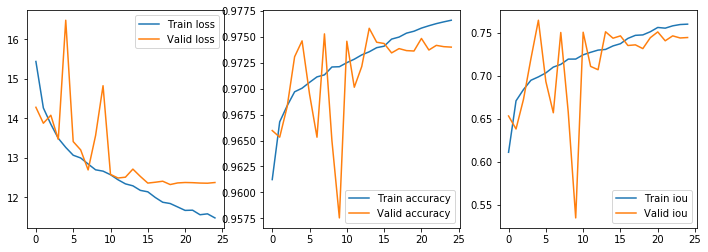

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


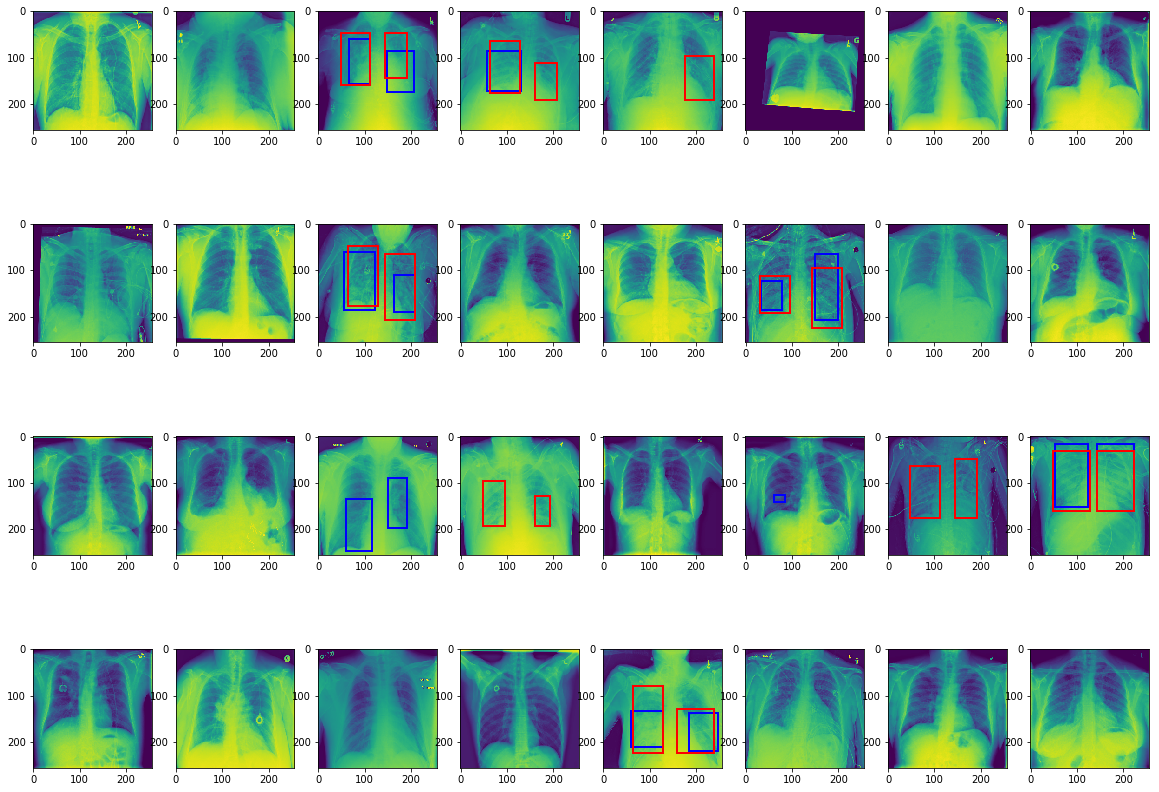

In [15]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break



---



**PREDICTION OF TEST IMAGES**


*   Creating the test sample generator applying the mask on it.
*   Drawing the bounding boxes according to the connected components.


*   Printing the submission.csv file to get the output as Patient ID and Predictionstrings



In [16]:
# load and shuffle filenames
folder = 'test/'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(sub)

n test samples: 3000


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


                                                                       PredictionString
patientId                                                                              
c129ed85-8cdc-4505-972e-661a36fd9234                                                   
22dc1729-86ba-40e5-9ae0-2a9e8e839f4c                                                   
1e8ea4d6-568b-4aae-b91b-1a1f0d13dbd2                                                   
2e0b62fd-fdff-4038-a06a-188d2a3aa8e3                                                   
28232a23-415f-4f4f-bef4-248f5e875438                                                   
307411ff-1d18-4fac-acec-bcf02ba27c0b                                                   
2cfa3844-c593-4893-9d82-29f48e32b864                                                   
c0d73fbe-80c5-44dc-94f8-85f757be171b                                                   
308d1be1-7a4a-460f-8429-0e02f1ca51fd                                                   
0524e490-8eee-4342-8813-870acac6